In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=20


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02

DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =100
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# check 2d grid and RHS


import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D


fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')

Z=np.sin(1)*X+np.cos(1)*Y
ax.plot_surface(X,Y,Z)

In [5]:
# Initial log message
logger.info("Test 2D problem using AX=b form. ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-16 23:27:08 [INFO] <ipython-input-5-04ad96fd4839> 2 - Test 2D problem using AX=b form. 


In [6]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2D(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,reslist_flat):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [7]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]
reslist_flat=[]

eps=0.0001

for ProbIdx in range(n_steps):

#     loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
#     b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)

    b=(np.sin(ProbIdx)+eps)*X+(np.cos(ProbIdx)+eps)*Y
    b_flat=np.reshape(b,(1,-1),order='F').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,reslist_flat)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]
    reslist_flat=OutList1[6]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,reslist_flat)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    reslist_flat=OutList2[6]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 1.9099268913269043
parameters 722
Initial Training
2
size 22
0.3046732776643342 0.21332813312971202
poor prediction,using initial x0
0.12698125702445395 0.13193161399976816 0.21332813312971113 0.21332813312971013
0.12698125702445395 0.13193161399976816 0.21332813312971113 0.21332813312971013
3
size 22
0.38352216099788733 0.21332813312971202
poor prediction,using initial x0
0.11323912101215683 0.12932552001439035 0.21332813312970986 0.21332813312971158
0.11323912101215683 0.12932552001439035 0.21332813312970986 0.21332813312971158
4
size 22
0.4380131185831154 0.21332813312971202
poor prediction,using initial x0
0.11797919697710313 0.12396338701364584 0.21332813312971338 0.213328133129711
0.11797919697710313 0.12396338701364584 0.21332813312971338 0.213328133129711
5
size 22
0.16937324994070213 0.21332813312971338
0.19615034500020556 0.11939985833790463 0.16937324994070213 0.21332813312971144
0.19615034500020556 0.11939985833790463 0.16937324994070213 0.21332813312971144


38
size 22
0.07426706495606583 0.21332813312971693
0.33656349798548035 0.18298725451924838 0.07426706495606583 0.1472472877730543
0.33656349798548035 0.18298725451924838 0.07426706495606583 0.1472472877730543
39
size 22
0.06476598088103654 0.21332813312971693
0.19927505101077259 0.18693146499805152 0.06476598088103654 0.14836169896940038
0.19927505101077259 0.18693146499805152 0.06476598088103654 0.14836169896940038
40
size 22
0.12260456372404265 0.21332813312971693
0.22115855300216936 0.18603025587857702 0.12260456372404265 0.14496476756090046
0.22115855300216936 0.18603025587857702 0.12260456372404265 0.14496476756090046
41
size 22
0.3343885461473186 0.21332813312971693
poor prediction,using initial x0
0.18785633001243696 0.18752812683815137 0.21332813312971077 0.14133582478467382
0.18785633001243696 0.18752812683815137 0.21332813312971077 0.14133582478467382
42
size 22
0.3618971369612153 0.21332813312971693
poor prediction,using initial x0
0.17009493699879386 0.19017310087918304 0.2

Final loss: 31.180940628051758
parameters 722
76
size 22
0.07228054785674631 0.21332813312971693
0.21454746500239708 0.224935227005044 0.07228054785674631 0.11058543629630281
0.21454746500239708 0.224935227005044 0.07228054785674631 0.11058543629630281
77
size 22
0.07939282425452991 0.21332813312971693
0.2190426790039055 0.22446032148553058 0.07939282425452991 0.11178274983568232
0.2190426790039055 0.22446032148553058 0.07939282425452991 0.11178274983568232
78
size 22
0.08297433639194239 0.21332813312971693
0.19586730099399574 0.2217688041657675 0.08297433639194239 0.1102380348679897
0.19586730099399574 0.2217688041657675 0.08297433639194239 0.1102380348679897
79
size 22
0.11499259228190374 0.21332813312971693
0.24062245100503787 0.21999779436504469 0.11499259228190374 0.10991529023410303
0.24062245100503787 0.21999779436504469 0.11499259228190374 0.10991529023410303
80
size 22
0.16062034285015614 0.21332813312971693
0.24107865898986347 0.22194823760422877 0.16062034285015614 0.1078750

2020-06-16 23:29:06 [INFO] <ipython-input-7-b99a56c3d21d> 84 - Runtime of Non-decorated version is:
2020-06-16 23:29:06 [INFO] <ipython-input-7-b99a56c3d21d> 85 - 23.080489591084188
2020-06-16 23:29:06 [INFO] <ipython-input-7-b99a56c3d21d> 87 - Runtime of MLGMRES decorator is:
2020-06-16 23:29:06 [INFO] <ipython-input-7-b99a56c3d21d> 88 - 80.50000467948848
2020-06-16 23:29:06 [INFO] <ipython-input-7-b99a56c3d21d> 91 - Runtime of training (backprop) is:
2020-06-16 23:29:06 [INFO] <ipython-input-7-b99a56c3d21d> 92 - 9.308136072970228


99


In [8]:
import matplotlib.pyplot as pp
from src_dir import *

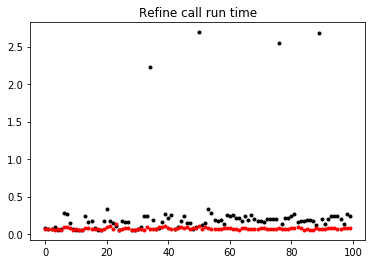

In [9]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')
# pp.ylim((0, 0.2))
pp.savefig('Test_2.png')

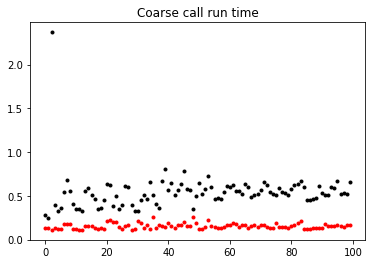

In [10]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')
pp.savefig('Test_1.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


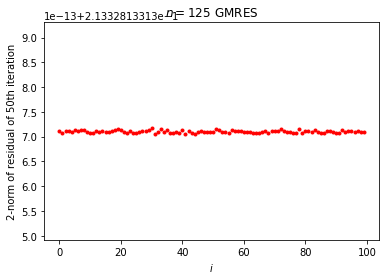

In [11]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[150:-1],AVG[150:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

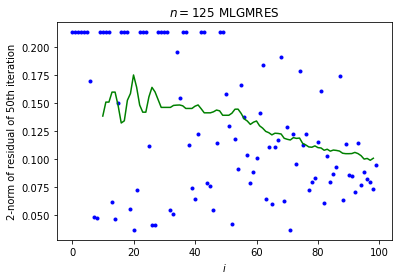

In [12]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

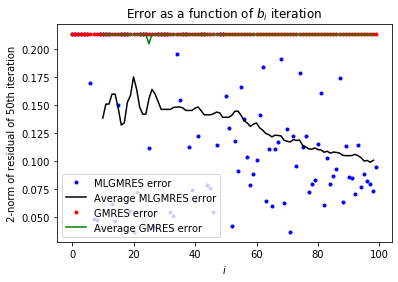

In [13]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

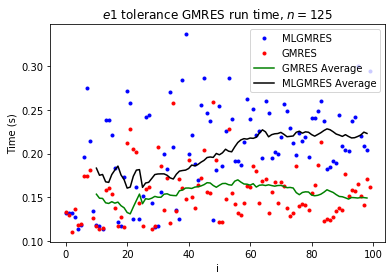

In [14]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')

#### 